In [3]:
import os
import glob
import cv2
import json
import numpy as np
from tqdm import tqdm
from pycocotools.coco import COCO
import matplotlib.pyplot as plt

In [421]:
DATASET_DIR = "_data/synthetic_leaf_instances"
#DATASET_DIR = "_data/validation/train"
#DATASET_DIR = "_data/leaf_detection"

ANNOTATION_FILE = "_data/coco_synthetic_val.json"
#ANNOTATION_FILE = "_data/validation/train/_annotations.coco.json"

OUT_DIR = "out/validation/synthetic"

In [422]:
os.makedirs(OUT_DIR, exist_ok=True)

In [423]:
!curl -L "https://universe.roboflow.com/ds/wHImMHnOYc?key=PxGuReUIO6" > roboflow.zip; unzip -o roboflow.zip -d {DATASET_DIR}; rm roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   914  100   914    0     0   3275      0 --:--:-- --:--:-- --:--:--  3264
100 18.3M  100 18.3M    0     0  6530k      0  0:00:02  0:00:02 --:--:-- 11.5M
Archive:  roboflow.zip
 extracting: _data/synthetic_leaf_instances/README.dataset.txt  
 extracting: _data/synthetic_leaf_instances/README.roboflow.txt  
   creating: _data/synthetic_leaf_instances/test/
 extracting: _data/synthetic_leaf_instances/test/122a_1_jpg.rf.31a5e78e018e6f667cd608d6794f944e.jpg  
 extracting: _data/synthetic_leaf_instances/test/18cb836c-f351-41e4-933a-fae2feb4b9ad___RS_Late_2_jpg.rf.95a1a31dade87ea6d4b1d6ff8791525f.jpg  
 extracting: _data/synthetic_leaf_instances/test/194y_3_jpg.rf.0de9d58c1177b0a65366b6a3b1567d1d.jpg  
 extracting: _data/synthetic_leaf_instances/test/20230317_090325_000117_jpg.rf.89f809113155d146fa3273a693510b03.jpg  
 extracting: _

In [424]:
total_anns = 0
total_imgs = 0
for directory in [file for file in os.listdir(DATASET_DIR) if os.path.isdir(os.path.join(DATASET_DIR, file))]:
    if directory != 'val':
        #continue
        pass
    globs = glob.glob(f"{os.path.join(DATASET_DIR, directory)}/*.json")
    #print(globs)
    if len(globs) == 0:
        continue
    annotation_file = globs[0]
    #annotation_file = ANNOTATION_FILE
    coco = COCO(annotation_file)
    cat_ids = coco.getCatIds()
    for img_data in coco.imgs.values():
        img_file = os.path.join(directory, img_data['file_name'])
        anns_ids = coco.getAnnIds(imgIds=img_data['id'], catIds=cat_ids, iscrowd=None)
        anns = coco.loadAnns(anns_ids)
        total_anns += len(anns)
        total_imgs += 1
    
print(f"#Images: {total_imgs}, #Annotations: {total_anns}, Annotations per Image: {total_anns/total_imgs}")

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
#Images: 351, #Annotations: 500, Annotations per Image: 1.4245014245014245


In [425]:
def extract_image_masks(directory, annotation_file=None):
    result = []
    if annotation_file is None:
        annotation_file = glob.glob(f"{directory}/*.json")[0]
    coco = COCO(annotation_file)
    cat_ids = coco.getCatIds()
    for img_data in coco.imgs.values():
        img_file = os.path.join(directory, img_data['file_name'])
        img = cv2.imread(img_file)
        anns_ids = coco.getAnnIds(imgIds=img_data['id'], catIds=cat_ids, iscrowd=None)
        anns = coco.loadAnns(anns_ids)
        anns.sort(key=lambda x: x["area"])
        masks = []
        for i, ann in enumerate(anns):
            ann_mask = coco.annToMask(ann)
            masks.append(ann_mask)
        result.append((img_data['id'], img_file, img, masks))
    return result

In [286]:
image_masks = []
image_masks += extract_image_masks(os.path.join(DATASET_DIR), ANNOTATION_FILE)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [432]:
image_masks = []
for directory in [file for file in os.listdir(DATASET_DIR) if os.path.isdir(os.path.join(DATASET_DIR, file))]:
    if directory != 'val':
        continue
        #pass
    print(f"Processing {directory}")
    image_masks += extract_image_masks(os.path.join(DATASET_DIR, directory, "images"), ANNOTATION_FILE)
print(f"Found {len(image_masks)}")

Processing val
loading annotations into memory...
Done (t=0.98s)
creating index...
index created!
Found 1999


In [7]:
from concurrent.futures import ThreadPoolExecutor, as_completed

def process_image_mask(img_filepath, mask_filepath):
    """Process a single image and its mask."""
    img = cv2.imread(img_filepath)
    mask = cv2.imread(mask_filepath)

    # Find unique colors in the mask and create binary masks
    uniques = np.unique(mask.reshape(-1, mask.shape[2]), axis=0)
    uniques = np.delete(uniques, [0, 0, 0], axis=0)
    masks = [(np.all(mask == unique, axis=-1).astype(np.uint8)) for unique in uniques]
    
    file = os.path.basename(img_filepath)
    
    return file, img, masks

def generate_image_masks_concurrent(dataset_dir, max_workers=8):
    """Generate image masks with concurrency."""
    image_masks = []
    tasks = []

    # Collect all tasks
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        for root, _, files in os.walk(dataset_dir):
            rgb_files = [f for f in files if "_rgb" in f and f.lower().endswith(('.jpg', '.jpeg', '.png'))]

            for rgb_file in rgb_files:
                img_filepath = os.path.join(root, rgb_file)
                mask_filepath = img_filepath.replace('_rgb', '_label')

                if not os.path.exists(mask_filepath):
                    continue

                # Submit the processing task
                tasks.append(executor.submit(process_image_mask, img_filepath, mask_filepath))
        
        # Gather results as they complete
        for future in tqdm(as_completed(tasks), total=len(tasks)):
            try:
                result = future.result()
                image_masks.append(result)
            except Exception as e:
                print(f"Error processing file: {e}")

    return image_masks

In [8]:
#image_masks = generate_image_masks_concurrent(DATASET2_DIR, 20)

In [427]:
len(image_masks)

1999

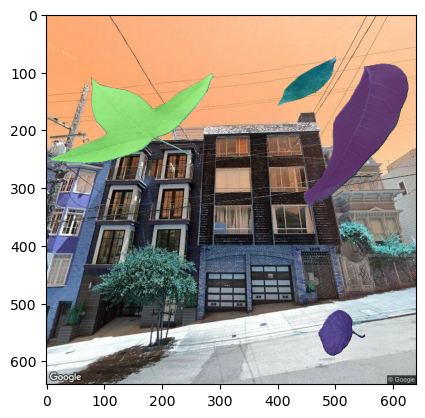

In [435]:
import random
img_id, file, image, masks = random.sample(image_masks, 1)[0]
plt.figure()
plt.imshow(image)
overlay = np.zeros(image.shape[:2] + (4,))
for mask in masks:
    binary_mask = mask == 1
    overlay[binary_mask, :] = np.concatenate([np.random.random(3), [.5]])
ax = plt.gca()
ax.set_autoscale_on(False)
plt.imshow(overlay)
plt.show()

In [66]:
def get_patches(masks, image, apply_mask=False, padding=0):
    result = []
    
    for mask in masks:
        if apply_mask:
            image_tmp = image * mask['segmentation'][:, :, np.newaxis]
            #image_tmp = image * torch.from_numpy(mask["segmentation"]).to(image.device).unsqueeze(-1)
        else:
            image_tmp = image
            
        bbox = mask["bbox"]
        x0 = bbox[1]-padding
        if x0 < 0:
            x0 = 0
        x1 = bbox[1]+bbox[3]+padding
        if x1 >= image.shape[0]:
            x1 = image.shape[0] - 1
        y0 = bbox[0]-padding
        if y0 < 0:
            y0 = 0
        y1 = bbox[0]+bbox[2]+padding
        if y1 >= image.shape[1]:
            y1 = image.shape[1] - 1
        
        patch = image_tmp[int(x0):int(x1), int(y0):int(y1)]
        
        if 0 in patch.shape:
            continue
        result.append(patch)
    
    return result

# PyTorch models

In [69]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torchvision.datasets import ImageFolder
from torchvision.models import resnet50, ResNet50_Weights

In [70]:
# Check if GPU is available
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [71]:
class BinaryResnetClassifier(nn.Module):
    def __init__(self, num_classes=1):
        super(BinaryResnetClassifier, self).__init__()
        # Load a pre-trained ResNet model
        self.resnet = resnet50(ResNet50_Weights.IMAGENET1K_V1)  # You can choose any ResNet variant
        # Modify the last fully connected layer
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)
        nn.init.xavier_normal_(self.resnet.fc.weight)
        
    def forward(self, x):
        # Pass the input through the ResNet
        x = self.resnet(x)
        # Apply the sigmoid activation function
#        x = torch.sigmoid(x)  # Output will be between 0 and 1
        return x

In [72]:
class BinaryInceptionClassifier(nn.Module):
    def __init__(self, num_classes=1):
        super(BinaryInceptionClassifier, self).__init__()
        # Load a pre-trained ResNet model
        self.inception = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True) # You can choose any ResNet variant
        # Modify the last fully connected layer
        self.inception.fc = nn.Linear(self.inception.fc.in_features, num_classes)
        nn.init.xavier_normal_(self.inception.fc.weight)
        
    def forward(self, x):
        # Pass the input through the ResNet
        x = self.inception(x)
        # Apply the sigmoid activation function
#        x = torch.sigmoid(x)  # Output will be between 0 and 1
        return x

In [73]:
class Encoder(nn.Module):
    def __init__(self, in_channels=3, out_channels=16, latent_dim=200, act_fn=nn.ReLU()):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1, stride=2),  # 112x112
            act_fn,
            nn.Conv2d(out_channels, 2*out_channels, 3, padding=1, stride=2),  # 56x56
            act_fn,
            nn.Conv2d(2*out_channels, 4*out_channels, 3, padding=1, stride=2),  # 28x28
            act_fn,
            nn.Conv2d(4*out_channels, 8*out_channels, 3, padding=1, stride=2),  # 14x14
            act_fn,
            nn.Conv2d(8*out_channels, 16*out_channels, 3, padding=1, stride=2),  # 7x7
            act_fn,
            nn.Flatten(),
            nn.Linear(16*out_channels*7*7, latent_dim),
            act_fn
        )

    def forward(self, x):
        return self.net(x)

class Decoder(nn.Module):
    def __init__(self, in_channels=3, out_channels=16, latent_dim=200, act_fn=nn.ReLU()):
        super().__init__()
        self.out_channels = out_channels
        self.linear = nn.Sequential(
            nn.Linear(latent_dim, 16*out_channels*7*7),
            act_fn
        )
        self.conv = nn.Sequential(
            nn.ConvTranspose2d(16*out_channels, 8*out_channels, 3, stride=2, padding=1, output_padding=1),  # 14x14
            act_fn,
            nn.ConvTranspose2d(8*out_channels, 4*out_channels, 3, stride=2, padding=1, output_padding=1),  # 28x28
            act_fn,
            nn.ConvTranspose2d(4*out_channels, 2*out_channels, 3, stride=2, padding=1, output_padding=1),  # 56x56
            act_fn,
            nn.ConvTranspose2d(2*out_channels, out_channels, 3, stride=2, padding=1, output_padding=1),  # 112x112
            act_fn,
            nn.ConvTranspose2d(out_channels, in_channels, 3, stride=2, padding=1, output_padding=1),  # 224x224
        )

    def forward(self, x):
        output = self.linear(x)
        output = output.view(-1, 16*self.out_channels, 7, 7)
        output = self.conv(output)
        return output

#  defining autoencoder
class BigAutoencoder(nn.Module):
    def __init__(self, encoder=Encoder(), decoder=Decoder()):
        super().__init__()
        self.encoder = encoder
#        self.encoder.to(device)

        self.decoder = decoder
#        self.decoder.to(device)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [74]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
from ultralytics import YOLO
import torchvision.transforms.v2 as transforms

yolo = YOLO("out/yolo_urban_street/train/weights/best.pt")
yolo_syn = YOLO("out/yolo_synthetic/train4/weights/best.pt")

resnet = torch.load("out/leaf_classifier/resnet_masked_cos/resnet_best.pth")
resnet = resnet.to(device)
resnet.eval()

resnet_transform = transforms.Compose([
    transforms.ToImage(),
    transforms.Resize((224, 224)),
    transforms.ToDtype(torch.float32, scale=True),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  
])

inception = torch.load("out/leaf_classifier/inception/inception_best.pth")
inception = inception.to(device)
inception.eval()

inception_transform = transforms.Compose([
    transforms.ToImage(),
    transforms.Resize((320, 320)),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  
])


autoencoder = torch.load("out/leaf_classifier/autoencoder/autoencoder_latest.pth")
autoencoder = autoencoder.to(device)
autoencoder.eval()

autoencoder_transform = transforms.Compose([
    transforms.ToImage(),
    transforms.Resize((224, 224)),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  
])

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

In [341]:
def predict_sam(img, pred, apply_mask=False):
    masks = mask_generator.generate(img)
    masks.sort(key=lambda x: x["area"])
    patches = get_patches(masks, img, apply_mask)
    result = []
    mask_result = []
    
    for i, (mask, patch) in enumerate(zip(masks, patches)):
        if 0 in patch.shape:
            continue
        include, prob = pred(patch)
        if include:
            result.append(mask["segmentation"] > 0)
        mask_result.append({
            "segmentation": mask['segmentation'],
            "confidence": prob,
            "patch": patch
        })
    return result, mask_result
    
def prep_img(img):
    return torch.Tensor(img).to(device).permute(2, 0, 1).unsqueeze(0)

def pred_autoencoder(x):
    x = autoencoder_transform(prep_img(x))
    with torch.no_grad():
        A = autoencoder(x).squeeze()
        A -= A.min(1, keepdim=True)[0]
        A /= A.max(1, keepdim=True)[0]
        A *= 255
        A = A.to(dtype=torch.uint8)
        similarity = nn.MSELoss()(A, x.squeeze()) / 100000
        sig = torch.sigmoid(similarity)
        return sig > .75, sig

def predict_sam_autoencoder(img):
    return predict_sam(img, pred_autoencoder, True)
    

def pred_resnet(x):
    x = resnet_transform(x).to(device).unsqueeze(0)
    with torch.no_grad():
        out = resnet(x)
        sig = torch.sigmoid(out).item()
        return sig < 0.025, 1 - sig    

def predict_sam_resnet(img):
    return predict_sam(img, pred_resnet, True)


def pred_inception(x):
    x = inception_transform(x).to(device).unsqueeze(0)
    with torch.no_grad():
        out = inception(x)
        sig = torch.sigmoid(out).item()
        return sig < 0.01, 1 - sig

def predict_sam_inception(img):
    return predict_sam(img, pred_inception, True)
    
def pred_yolo(x):
    prediction = yolo.predict(x, verbose=False)[0]
    return prediction.masks is not None, prediction.boxes.conf.cpu().numpy()
    
def predict_sam_yolo(img):
    return predict_sam(img, pred_yolo)

def predict_yolo(img):
    masks_result = []
    result = yolo_syn.predict(img, verbose=False, retina_masks=True)[0]
    if result.masks is None:
        return [], []
    masks = result.masks.data
    boxes = result.boxes.data
    names = list(result.names.values())
    
    classes = boxes[:, 5]
    
    for i, name in enumerate(names):
        obj_indices = torch.where(classes == i)
        obj_masks = masks[obj_indices]
        obj_masks = torch.nn.functional.interpolate(obj_masks.unsqueeze(0), size=image.shape[:2], mode='bilinear', align_corners=False).squeeze(0)
        prob = result[0].boxes.conf
        
        segmentations = [seg.cpu().numpy() for seg in torch.unbind(obj_masks)]
        
        for i, seg in enumerate(segmentations):
            patch = image * seg[:, :, np.newaxis].astype(np.uint8)
            coords = cv2.findNonZero(seg)  # Returns all non-zero points
            x, y, w, h = cv2.boundingRect(coords)  # Get bounding box
            
            patch = patch[y:y+h, x:x+w]
            masks_result.append({
                "segmentation": seg,
                "confidence": result.boxes.conf.cpu().numpy()[i],
                "patch": patch
            })
    return [el['segmentation'] > 0 for el in masks_result], masks_result

In [342]:
prediction_dict = {
    "SAM + Autoencoder": predict_sam_autoencoder,
    "SAM + Inception": predict_sam_inception,
    "YOLOv8": predict_yolo,
    "SAM + ResNet": predict_sam_resnet,
    "SAM + YOLOv8": predict_sam_yolo,
}

# Tensorflow Models

In [18]:
import os
import cv2
import numpy as np
from PIL import Image
import tensorflow as tf
import tensorflow_models as tfm
from official.vision.utils.object_detection import visualization_utils
from official.vision.ops.preprocess_ops import normalize_image, resize_and_crop_image
tf.get_logger().setLevel('ERROR')

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
    path: the file path to the image

    Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
    """
    image = None
    if(path.startswith('http')):
        response = urlopen(path)
        image_data = response.read()
        image_data = BytesIO(image_data)
        image = Image.open(image_data)
    else:
        image = Image.open(path)

    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
      (1, im_height, im_width, 3)).astype(np.uint8)

def build_inputs_for_object_detection(image, input_image_size):
    """Builds Object Detection model inputs for serving."""
    return cv2.resize(image.squeeze(), input_image_size)
    image, _ = resize_and_crop_image(
      image,
      input_image_size,
      padded_size=input_image_size,
      aug_scale_min=1.0,
      aug_scale_max=1.0)
    return image

In [ ]:
def reframe_image_corners_relative_to_boxes(boxes):
    """Reframe the image corners ([0, 0, 1, 1]) to be relative to boxes.
    The local coordinate frame of each box is assumed to be relative to
    its own for corners.
    Args:
    boxes: A float tensor of [num_boxes, 4] of (ymin, xmin, ymax, xmax)
      coordinates in relative coordinate space of each bounding box.
    Returns:
    reframed_boxes: Reframes boxes with same shape as input.
    """
    ymin, xmin, ymax, xmax = (boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3])

    height = tf.maximum(ymax - ymin, 1e-4)
    width = tf.maximum(xmax - xmin, 1e-4)

    ymin_out = (0 - ymin) / height
    xmin_out = (0 - xmin) / width
    ymax_out = (1 - ymin) / height
    xmax_out = (1 - xmin) / width
    return tf.stack([ymin_out, xmin_out, ymax_out, xmax_out], axis=1)

def reframe_box_masks_to_image_masks(box_masks, boxes, image_height,
                                     image_width, resize_method='bilinear'):
    """Transforms the box masks back to full image masks.
    Embeds masks in bounding boxes of larger masks whose shapes correspond to
    image shape.
    Args:
    box_masks: A tensor of size [num_masks, mask_height, mask_width].
    boxes: A tf.float32 tensor of size [num_masks, 4] containing the box
           corners. Row i contains [ymin, xmin, ymax, xmax] of the box
           corresponding to mask i. Note that the box corners are in
           normalized coordinates.
    image_height: Image height. The output mask will have the same height as
                  the image height.
    image_width: Image width. The output mask will have the same width as the
                 image width.
    resize_method: The resize method, either 'bilinear' or 'nearest'. Note that
      'bilinear' is only respected if box_masks is a float.
    Returns:
    A tensor of size [num_masks, image_height, image_width] with the same dtype
    as `box_masks`.
    """
    resize_method = 'nearest' if box_masks.dtype == tf.uint8 else resize_method
    # TODO(rathodv): Make this a public function.
    def reframe_box_masks_to_image_masks_default():
        """The default function when there are more than 0 box masks."""

        num_boxes = tf.shape(box_masks)[0]
        box_masks_expanded = tf.expand_dims(box_masks, axis=3)

        resized_crops = tf.image.crop_and_resize(
            image=box_masks_expanded,
            boxes=reframe_image_corners_relative_to_boxes(boxes),
            box_indices=tf.range(num_boxes),
            crop_size=[image_height, image_width],
            method=resize_method,
            extrapolation_value=0)
        return tf.cast(resized_crops, box_masks.dtype)

    image_masks = tf.cond(
        tf.shape(box_masks)[0] > 0,
        reframe_box_masks_to_image_masks_default,
        lambda: tf.zeros([0, image_height, image_width, 1], box_masks.dtype))
    return tf.squeeze(image_masks, axis=3)

def reframe_masks(masks, boxes, image_shape):
    result = []
    for box, mask in zip(boxes, masks):
        box = tf.cast(box, np.uint16)
        box = box.numpy()
        if len(np.unique(box)) == 1:
            continue
        mask = mask.numpy()
        ymin, xmin, ymax, xmax = (box[0], box[1], box[2], box[3])
        box_width = xmax - xmin
        box_height = ymax - ymin
        mask_resized = cv2.resize(mask, (box_width, box_height))
        total_mask = np.zeros(image_shape[:2])

        total_mask[ymin:ymax, xmin:xmax] = mask_resized
        result.append(total_mask)
    return np.stack(result) if len(result) > 0 else np.array([])

In [ ]:
imported = tf.saved_model.load("out/maskrcnn_resnet_fpn_16_09_24/final")
model_fn = imported.signatures['serving_default']

In [ ]:
def predict_maskrcnn(image):
    min_score_thresh = .2
    input_image_size = (640, 640)
    image_tf = tf.convert_to_tensor(image)
    image_tf = tf.expand_dims(image_tf, axis=0)
    image_tf = tf.cast(image_tf, dtype = tf.uint8)
    result = model_fn(image_tf)
    if 'detection_masks' in result:
        detection_masks = tf.convert_to_tensor(result['detection_masks'][0])
        detection_boxes = tf.convert_to_tensor(result['detection_boxes'][0])
#        detection_masks_reframed = reframe_box_masks_to_image_masks(
#                  detection_masks, detection_boxes/256.0,
#                    image.shape[0], image.shape[1])
        detection_masks_reframed = reframe_masks(detection_masks, detection_boxes, image.shape)
        detection_masks_reframed = tf.cast(
            detection_masks_reframed > min_score_thresh,
            np.uint8)
        masks = []
        for mask in detection_masks_reframed:
            mask = mask.numpy()
            # skip empty masks
            if (len(np.unique(mask)) == 1):
                continue
            else:
                masks.append(mask)
        return masks
    else:
        return []

In [ ]:
prediction_dict = {
    "MaskRCNN": predict_maskrcnn,
}

In [ ]:
import random
img_files = [file for file in [os.path.join("_data/combined/test", file) for file in random.sample(os.listdir("_data/combined/test"), k=1)] if os.path.isfile(file)]

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
# code source from
# https://github.com/tensorflow/models/blob/master/docs/vision/instance_segmentation.ipynb

HEIGHT = 640
WIDTH = 640
input_image_size = (HEIGHT, WIDTH)
plt.figure(figsize=(20, 20))
min_score_thresh = 0.10 # Change minimum score for threshold to see all bounding boxes confidences

category_index = {
    0: {
        'id': 0,
        'name': 'background'
    },
    1: {
        'id': 32,
        'name': 'leaf'
    },
}

for i, img_file in enumerate(img_files):
    plt.subplot(1, 3, i+1)
    image = load_image_into_numpy_array(img_file)
    image = build_inputs_for_object_detection(image, input_image_size)
    image = tf.expand_dims(image, axis=0)
    image = tf.cast(image, dtype = tf.uint8)
    image_np = image[0].numpy()
    result = model_fn(image)
    print(result.keys())
    # Visualize detection and masks
    if 'detection_masks' in result:
        # we need to convert np.arrays to tensors
        detection_masks = tf.convert_to_tensor(result['detection_masks'][0])
        detection_boxes = tf.convert_to_tensor(result['detection_boxes'][0])
        detection_masks_reframed = reframe_box_masks_to_image_masks(
                  detection_masks, detection_boxes/256.0,
                    image_np.shape[0], image_np.shape[1])
        detection_masks_reframed = reframe_masks(detection_masks, detection_boxes, image_np.shape)
#        print(detection_masks_reframed.numpy().max())
        detection_masks_reframed = tf.cast(
            detection_masks_reframed > min_score_thresh,
            np.uint8)
        
        result['detection_masks_reframed'] = detection_masks_reframed.numpy()
    print(result['detection_boxes'].numpy().max())
    image_np = cv2.cvtColor(image_np, cv2.COLOR_BGR2GRAY)
    image_np = np.stack((image_np,)*3, axis=-1)
    visualization_utils.visualize_boxes_and_labels_on_image_array(
        image_np,
        result['detection_boxes'][0].numpy(),
        (result['detection_classes'][0] + 0).numpy().astype(int),
        result['detection_scores'][0].numpy(),
        category_index=category_index,
        use_normalized_coordinates=False,
        max_boxes_to_draw=100,
        min_score_thresh=min_score_thresh,
        instance_masks=result.get('detection_masks_reframed', None),
        line_thickness=4)
    
    plt.imshow(image_np, cmap='gray')
    plt.axis("off")

plt.show()

In [ ]:
%matplotlib inline
img_file = img_files[0]
image = load_image_into_numpy_array(img_file)
image = build_inputs_for_object_detection(image, input_image_size)
image = tf.expand_dims(image, axis=0)
image = tf.cast(image, dtype = tf.uint8)
image_np = image[0].numpy()
output = model_fn(image)

combined_masks = np.zeros(image_np.shape[:2])

for i, (box, mask) in enumerate(zip(output["detection_boxes"][0], output["detection_masks"][0])):
    box = tf.cast(box, np.uint16)
    box = box.numpy()
    if len(np.unique(box)) == 1:
        continue
    mask = mask.numpy()
    ymin, xmin, ymax, xmax = (box[0], box[1], box[2], box[3])
    box_width = xmax - xmin
    box_height = ymax - ymin
    mask_resized = cv2.resize(mask, (box_width, box_height))
    total_mask = np.zeros(image_np.shape[:2])
    
    total_mask[ymin:ymax, xmin:xmax] = mask_resized
    combined_masks[total_mask > .2] = i
    
plt.imshow(combined_masks)
plt.axis('off')
plt.show()

# Test execution

In [77]:
%matplotlib inline
def compare_segmentation_masks(mask1, mask2, img):
    # Ensure that both masks are binary and of the same shape
    assert mask1.shape == mask2.shape, "Masks must have the same shape"
    
    # Create a figure and clear any previous plots
    plt.figure(figsize=(10, 5))
    plt.clf()  # Clear the figure to overwrite the previous one

    # Plot the first mask
    plt.subplot(1, 4, 1)
    plt.title('Mask 1')
    plt.imshow(mask1, cmap='gray')
    plt.axis('off')

    # Plot the second mask
    plt.subplot(1, 4, 2)
    plt.title('Mask 2')
    plt.imshow(mask2, cmap='gray')
    plt.axis('off')

    # Create a difference mask (where masks disagree)
    difference_mask = (mask1 != mask2).astype(np.float32)

    # Plot the difference between the two masks
    plt.subplot(1, 4, 3)
    plt.title('Difference (Mask1 != Mask2)')
    plt.imshow(difference_mask, cmap='Reds')
    plt.axis('off')
    
    plt.subplot(1, 4, 4) # Plot the difference between the two masks
    plt.title('Image')
    plt.imshow(img)
    plt.axis('off')

    # Show the comparison
    plt.tight_layout()
    plt.show()

In [78]:
import pandas as pd

In [79]:
def iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    if union == 0:
        return 0
    return intersection / union

# Function to calculate Dice coefficient between two masks
def dice(mask1, mask2):
    intersection = np.logical_and(mask1, mask2).sum()
    sum_areas = mask1.sum() + mask2.sum()
    if sum_areas == 0:
        return 0
    return 2 * intersection / sum_areas

In [80]:
from scipy.optimize import linear_sum_assignment

def match_masks(pred_masks, gt_masks, iou_threshold=0.5):
    iou_matrix = np.zeros((len(pred_masks), len(gt_masks)))

    # Calculate IoU for each pair of predicted and ground truth masks
    for i, pred in enumerate(pred_masks):
        for j, gt in enumerate(gt_masks):
            iou_matrix[i, j] = iou(pred, gt)

    # Use Hungarian algorithm for optimal matching
    pred_indices, gt_indices = linear_sum_assignment(-iou_matrix)

    # True Positives (TP), False Positives (FP), False Negatives (FN)
    tp = 0
    fp = 0
    fn = 0
    matched_pairs = []
    iou_scores = []
    dice_scores = []

    for i, j in zip(pred_indices, gt_indices):
        if iou_matrix[i, j] >= iou_threshold:
            tp += 1
            matched_pairs.append((i, j))  # Store matched pairs for further analysis
            iou_scores.append(iou_matrix[i, j])  # IoU for this matched pair
            dice_scores.append(dice(pred_masks[i], gt_masks[j]))  # Dice for this matched pair
        else:
            fp += 1

    fn = len(gt_masks) - tp  # Unmatched ground truth masks are false negatives
    fp += len(pred_masks) - tp  # Unmatched predicted masks are false positives

    return tp, fp, fn, matched_pairs, iou_scores, dice_scores

In [81]:
# Function to calculate True Negatives (TN)
def calculate_true_negatives(gt_masks, pred_masks):
    # Combine all gt_masks into one binary mask (0: background, 1: object)
    gt_combined = np.sum(gt_masks, axis=0) > 0
    pred_combined = np.sum(pred_masks, axis=0) > 0
    
    # Calculate True Negatives
    true_negative_mask = np.logical_and(gt_combined == 0, pred_combined == 0)
    tn = np.sum(true_negative_mask)
    
    return tn

In [82]:
def compute_metrics(tp, fp, fn, tn):
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return precision, recall, specificity, f1_score

In [83]:
def evaluate_instance_segmentation(gt_masks, pred_masks, iou_threshold=0.5):
    tp, fp, fn, matched_pairs, iou_scores, dice_scores = match_masks(pred_masks, gt_masks, iou_threshold)
    
    # Calculate True Negatives
    tn = calculate_true_negatives(gt_masks, pred_masks)
    
    # Calculate Precision, Recall, Specificity, and F1 Score
    precision, recall, specificity, f1_score = compute_metrics(tp, fp, fn, tn)
    
    # Calculate mean IoU and mean Dice score
    mean_iou = np.mean(iou_scores) if iou_scores else 0
    mean_dice = np.mean(dice_scores) if dice_scores else 0
    
    return {
        "true_positives": tp,
        "false_positives": fp,
        "false_negatives": fn,
        "precision": precision,
        "recall": recall,
        "f1_score": f1_score,
        "mean_iou": mean_iou,
        "mean_dice": mean_dice,
        "specificity": specificity
    }

In [84]:
# Create a custom Dataset
class ImageMaskDataset(torch.utils.data.Dataset):
    def __init__(self, image_masks):
        self.image_masks = image_masks  # Store the list of tuples

    def __len__(self):
        return len(self.image_masks)  # Total number of samples

    def __getitem__(self, idx):
        # Return a single (image, gt_mask) pair
        return self.image_masks[idx]

In [85]:
# Wrap the list in the custom Dataset
image_mask_dataset = ImageMaskDataset(image_masks)

# Use DataLoader to handle batching
batch_size = 1
data_loader = DataLoader(image_mask_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

(114, 119, 3)


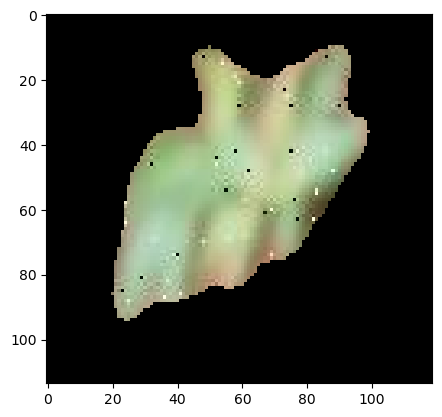

(114, 119, 3)
tensor([[-8.3795]], device='cuda:0')
tensor([[-18.3410]], device='cuda:0')
tensor(255., device='cuda:0')


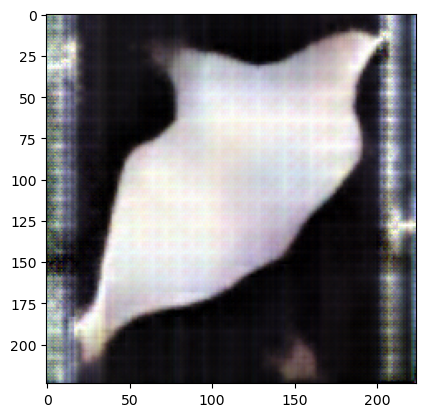

torch.Size([3, 224, 224]) torch.Size([1, 3, 224, 224])
tensor(0.8561, device='cuda:0') tensor(0.7018, device='cuda:0')


/tmp/ipykernel_2145868/3897733422.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  similarity = nn.MSELoss()(torch.tensor(A), prepped.squeeze()) / 100000


In [343]:
import matplotlib.pyplot as plt

image_id, file, img, _ = next(iter(data_loader))
img = img.squeeze().cpu().numpy()
masks = mask_generator.generate(img)
masks.sort(key=lambda x: x["area"], reverse=True)
patches = get_patches(masks, img, True, padding=20)
INDEX = 6
patch = patches[INDEX]
print(patch.shape)
patch = cv2.cvtColor(patch, cv2.COLOR_RGB2BGR)
plt.imshow(patch)
plt.show()

with torch.no_grad():
    prepped = patch
    print(prepped.shape)
    print(inception(inception_transform(prepped).to(device).unsqueeze(0)))
    print(resnet(resnet_transform(prepped).to(device).unsqueeze(0)))
    print(prep_img(patch).max())
    prepped = autoencoder_transform(prep_img(patch))
    A = autoencoder(prepped).squeeze()
    A -= A.min(1, keepdim=True)[0]
    A /= A.max(1, keepdim=True)[0]
    A *= 255
    A = A.to(dtype=torch.uint8)
    plt.imshow(A.cpu().permute((1,2,0)).numpy())
    plt.show()
    print(A.shape, prepped.shape)
    similarity = nn.MSELoss()(torch.tensor(A), prepped.squeeze()) / 100000
    print(similarity, torch.sigmoid(similarity))

In [436]:
sam_predictions = {
    "SAM + Autoencoder": (pred_autoencoder, True),
    "SAM + Inception": (pred_inception, True),
    "SAM + ResNet": (pred_resnet, True),
    "SAM + YOLOv8": (pred_yolo, False),
}

other_predictions = {
    "YOLOv8": predict_yolo
}

In [437]:
import pickle
import queue
import threading

class PickleWriter:
    def __init__(self, base_dir="out/validation/intermediate"):
        """
        Initialize a thread-safe pickle writer with a queue
        
        Args:
            base_dir (str): Base directory for saving pickle files
        """
        self.base_dir = base_dir
        self.queue = queue.Queue(maxsize=100)  # Limit queue size to prevent unbounded memory growth
        self.stop_event = threading.Event()
        self.thread = threading.Thread(target=self._worker, daemon=True)
        self.thread.start()

    def _worker(self):
        """
        Background worker that continuously writes pickle files from the queue
        """
        while not self.stop_event.is_set():
            try:
                # Use a timeout to periodically check stop_event
                name, bn, pkl_data = self.queue.get(timeout=1)
                
                # Ensure directory exists
                os.makedirs(os.path.join(self.base_dir, name), exist_ok=True)
                
                # Write pickle file
                with open(f"{self.base_dir}/{name}/{bn}.pkl", "wb+") as f:
                    pickle.dump(pkl_data, f)
                
                self.queue.task_done()
            except queue.Empty:
                continue
            except Exception as e:
                print(f"Error in pickle writer: {e}")

    def add_task(self, name, bn, pkl_data):
        """
        Add a pickle task to the queue
        
        Args:
            name (str): Subdirectory name
            bn (str): Base filename
            pkl_data (dict): Data to be pickled
        """
        try:
            # Non-blocking put with a timeout to handle full queue
            self.queue.put((name, bn, pkl_data), block=False)
        except queue.Full:
            # If queue is full, block and wait
            self.queue.put((name, bn, pkl_data))

    def close(self):
        """
        Gracefully stop the pickle writer thread
        """
        self.stop_event.set()
        self.thread.join()

In [439]:
SKIP_EXISTING = False
existing = {}

PRED_OUT_DIR = "out/validation/intermediate/synthetic"

for key in list(sam_predictions.keys()) + list(other_predictions.keys()):
    os.makedirs(os.path.join(PRED_OUT_DIR, key), exist_ok=True)
    existing[key] = os.listdir(os.path.join(PRED_OUT_DIR, key))

# Initialize pickle writer
pickle_writer = PickleWriter(base_dir=PRED_OUT_DIR)

p_bar = tqdm(image_masks, desc="Executing")

try:
    for img_id, file, img, gt_masks in p_bar:
        bn = os.path.splitext(os.path.basename(file))[0]

        # Skip if all predictions already exist
        if SKIP_EXISTING and all([f"{bn}.pkl" in existing[name] for name in list(sam_predictions.keys()) + list(other_predictions.keys())]):
            continue

        # Generate masks
        p_bar.set_description("Generating patches")
        masks = mask_generator.generate(img)
        masks.sort(key=lambda x: x["area"])
        patches_masked = get_patches(masks, img, True)
        patches = get_patches(masks, img)

        # Process SAM predictions
        for name, (func, masked) in sam_predictions.items():
            p_bar.set_description(f"Evaluating patches with {name}")
            if SKIP_EXISTING and f"{bn}.pkl" in existing[name]:
                continue

            result = []
            mask_result = []
            for i, (mask, patch, patch_masked) in enumerate(zip(masks, patches, patches_masked)):
                if 0 in patch.shape:
                    continue
                include, prob = func(patch_masked if masked else patch)
                if include:
                    result.append(mask["segmentation"] > 0)
                mask_result.append({
                    "segmentation": mask['segmentation'],
                    "confidence": prob,
                    "patch": patch,
                })

            pkl = {
                "file": file,
                "data": mask_result,
                "img_id": img_id,
            }

            # Fire and forget - add to queue
            pickle_writer.add_task(name, bn, pkl)

        # Process other predictions
        for name, func in other_predictions.items():
            p_bar.set_description(f"Evaluating {name}")
            if SKIP_EXISTING and f"{bn}.pkl" in existing[name]:
                continue

            pred_masks, data = func(img)
            pkl = {
                "file": file,
                "data": data,
                "img_id": img_id
            }

            # Fire and forget - add to queue
            pickle_writer.add_task(name, bn, pkl)
            del data
finally:
    # Ensure pickle writer is closed
    pickle_writer.close()

Evaluating YOLOv8: 100%|██████████| 1999/1999 [2:54:09<00:00,  5.23s/it]                          


In [458]:
elements = {
    "SAM + Inception": .9,
    "SAM + ResNet": .975,
    "SAM + Autoencoder": .75,
    "SAM + YOLOv8": 0,
    "YOLOv8": 0
}

In [460]:
from concurrent.futures import ThreadPoolExecutor, as_completed
import pickle

MAX_WORKERS = 32

results = dict()
result_dfs = dict()

for name, func in prediction_dict.items():
    df = pd.DataFrame()
    result = []
    tasks = []
        
    with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
        # Submit evaluation tasks while generating predictions
        for id, file, img, gt_masks in tqdm(image_masks, desc=f"Evaluating {name}"):
            prediction_file = f"{PRED_OUT_DIR}/{name}/{os.path.splitext(os.path.basename(file))[0]}.pkl"
            if not os.path.exists(prediction_file):
                continue
            with open(prediction_file, "rb") as f:
                pred_data = pickle.load(f)

            if not pred_data['data'] or len(pred_data['data']) == 0:
                pred_masks = []
            else:
                pred_masks = []
                
                for data in pred_data['data']:
                    try:
                        if "confidence" in data and data["confidence"] > elements[name]:
                            pred_masks.append(data['segmentation'])
                    except:
                        pred_masks = []

            tasks.append(executor.submit(evaluate_instance_segmentation, gt_masks, pred_masks))

        # Collect evaluation results as they complete
        for future in tqdm(as_completed(tasks), total=len(tasks), desc=f"Processing Results for {name}"):
            try:
                eval_results = future.result()
                df = pd.concat([df, pd.DataFrame(eval_results, index=range(len(eval_results)))], ignore_index=True)
                result.append(eval_results)
            except Exception as e:
                print(f"Error during evaluation: {e}")

    # Store results and save DataFrame to CSV
    results[name] = result
    result_dfs[name] = df
    df.to_csv(os.path.join(OUT_DIR, f"{name}.csv"), index=False)

Evaluating SAM + YOLOv8:   0%|          | 0/1999 [00:00<?, ?it/s]/tmp/ipykernel_2145868/2858596679.py:32: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if "confidence" in data and data["confidence"] > elements[name]:
Processing Results for SAM + YOLOv8: 100%|██████████| 1999/1999 [00:00<00:00, 2482.83it/s]


# COCO Eval

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!


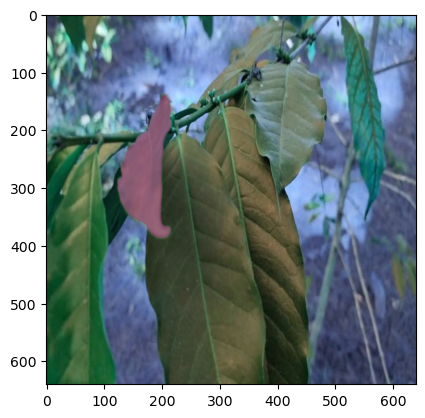

In [370]:
import glob
import random
import pickle

from pycocotools import mask as mask_utils

def resize_mask(mask, original_size):
    """
    Resize a binary segmentation mask to the original image size.

    Args:
        mask (np.ndarray): Predicted mask of size 640x640.
        original_size (tuple): Original image size (height, width).

    Returns:
        np.ndarray: Resized binary mask.
    """
    return cv2.resize(mask, (original_size[1], original_size[0]), interpolation=cv2.INTER_NEAREST)

def visualize_comparison_coco(annotation_file, image_dir, prediction_file):
    """
    Randomly samples an image from the COCO dataset and compares GT masks with predicted masks.

    Args:
        annotation_file (str): Path to the COCO annotation JSON file.
        image_dir (str): Directory containing COCO images.
        prediction_file (str): Path to the pickle file containing predictions.
    """
    # Load COCO data
    coco = COCO(annotation_file)

    # Load predictions
    with open(prediction_file, "rb") as f:
        pred_data = pickle.load(f)

    # Get list of images in the dataset
    image_ids = list(coco.imgs.keys())

    # Randomly sample an image
    sampled_image_id = pred_data["img_id"]
    image = cv2.imread(pred_data['file'])
    
    predictions = []
            
    for entry in pred_data["data"]:
        if entry['confidence'] < .99:
            continue
        binary_mask = entry["segmentation"]  # Binary mask (2D array)
        category_id = entry.get("category_id", 1)  # Default to category 1
        score = entry.get("score", 1.0)  # Default score if not provided

        resized_mask = resize_mask(binary_mask.astype("uint8"), image.shape[:2])

        # Convert binary mask to COCO RLE format
        rle = mask_utils.encode(np.asfortranarray(resized_mask))
        rle["counts"] = rle["counts"].decode("utf-8")  # Ensure counts is JSON serializable

        # Compute bounding box and area from the binary mask
        bbox = mask_utils.toBbox(rle).tolist()
        area = float(mask_utils.area(rle))

        predictions.append({
            "image_id": sampled_image_id,
            "category_id": category_id,
            "segmentation": rle,
            "bbox": bbox,
            "area": area,
            "score": score,
        })
    if len(predictions) == 0:
        print("No predictions")
        return

    # Evaluate predictions using COCOEvaluator
    coco_dt = coco.loadRes(predictions)
    annIds = coco_dt.getAnnIds(imgIds=[sampled_image_id])
    anns = coco_dt.loadAnns(annIds)
    plt.imshow(image)
    coco_dt.showAnns(anns)
    plt.show()

pkl_file = random.sample(glob.glob("out/validation/intermediate/real/SAM + Inception/*"), k=1)[0]

visualize_comparison_coco(ANNOTATION_FILE, DATASET_DIR, pkl_file)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
_data/validation/train/121_jpg.rf.2faa31c59222706b810376614e03fdf3.jpg _data/validation/train/121_jpg.rf.2faa31c59222706b810376614e03fdf3.jpg


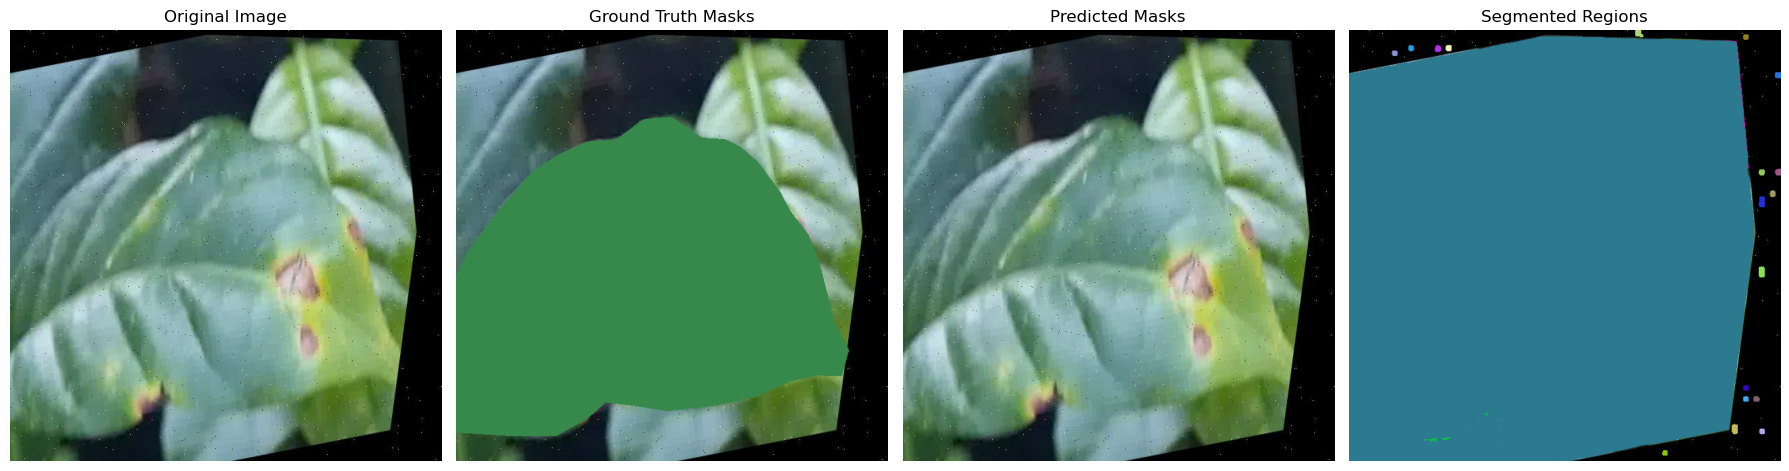

In [379]:
import glob

def visualize_comparison(annotation_file, image_dir, prediction_file):
    """
    Randomly samples an image from the COCO dataset and compares GT masks with predicted masks.

    Args:
        annotation_file (str): Path to the COCO annotation JSON file.
        image_dir (str): Directory containing COCO images.
        prediction_file (str): Path to the pickle file containing predictions.
    """
    # Load COCO data
    coco = COCO(annotation_file)

    # Load predictions
    with open(prediction_file, "rb") as f:
        pred_data = pickle.load(f)

    # Get list of images in the dataset
    image_ids = list(coco.imgs.keys())

    # Randomly sample an image
    sampled_image_id = pred_data["img_id"]
    image_info = coco.loadImgs(sampled_image_id)[0]
    image_path = os.path.join(image_dir, image_info["file_name"])
    print(image_path, pred_data['file'])
    original_image = cv2.imread(image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    # Load GT masks for the sampled image
    annotation_ids = coco.getAnnIds(imgIds=sampled_image_id)
    annotations = coco.loadAnns(annotation_ids)

    gt_masks = []
    for ann in annotations:
        gt_mask = coco.annToMask(ann)
        gt_masks.append(gt_mask)

    # Load predicted masks for the sampled image
    predictions = pred_data['data']
    pred_masks = []
    for prediction in predictions:
        if prediction['confidence'] < .98:
            continue
        resized_pred_mask = resize_mask(prediction["segmentation"].astype(np.uint8), (image_info["height"], image_info["width"]))
        pred_masks.append(resized_pred_mask)

    # Visualize the image, GT masks, and predicted masks
    fig, axs = plt.subplots(1, 4, figsize=(18, 6))

    # Display the original image
    axs[0].imshow(original_image)
    axs[0].set_title("Original Image")
    axs[0].axis("off")

    # Overlay GT masks
    gt_overlay = original_image.copy()
    for mask in gt_masks:
        color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
        gt_overlay[mask > 0] = color
    axs[1].imshow(gt_overlay)
    axs[1].set_title("Ground Truth Masks")
    axs[1].axis("off")

    # Overlay predicted masks
    pred_overlay = original_image.copy()
    for mask in pred_masks:
        color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
        pred_overlay[mask > 0] = color
    axs[2].imshow(pred_overlay)
    axs[2].set_title("Predicted Masks")
    axs[2].axis("off")
    
    pred_overlay = original_image.copy()
    for prediction in predictions:
        resized_pred_mask = resize_mask(prediction["segmentation"].astype(np.uint8), (image_info["height"], image_info["width"]))
        color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
        pred_overlay[resized_pred_mask > 0] = color
    axs[3].imshow(pred_overlay)
    axs[3].set_title("Segmented Regions")
    axs[3].axis("off")

    plt.tight_layout()
    plt.show()

pkl_file = random.sample(glob.glob("out/validation/intermediate/real/SAM + ResNet/*"), k=1)[0]

visualize_comparison(ANNOTATION_FILE, DATASET_DIR, pkl_file)

In [311]:
import os
import cv2
import pickle
import pandas as pd
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from pycocotools import mask as mask_utils

def resize_mask(mask, original_size):
    """
    Resize a binary segmentation mask to the original image size.

    Args:
        mask (np.ndarray): Predicted mask of size 640x640.
        original_size (tuple): Original image size (height, width).

    Returns:
        np.ndarray: Resized binary mask.
    """
    return cv2.resize(mask, (original_size[1], original_size[0]), interpolation=cv2.INTER_NEAREST)


def evaluate_pickled_predictions(prediction_dir, annotation_file, confidence_threshold):
    """
    Evaluate predictions from pickled files using COCOEvaluator, converting binary masks to COCO RLE format.

    Args:
        prediction_dir (str): Directory containing pickle files with predictions.
        annotation_file (str): COCO JSON annotation file for ground truth.
        output_csv (str): Path to save the evaluation results as a CSV file.
    """
    # Load ground truth COCO data
    coco_gt = COCO(annotation_file)

    # Prepare a list to store evaluation results
    results = []

    # Process each pickle file
    for pred_file in tqdm(os.listdir(prediction_dir)):
        if pred_file.endswith(".pkl"):
            pred_path = os.path.join(prediction_dir, pred_file)
            
            # Load pickled data
            with open(pred_path, "rb") as f:
                pred_data = pickle.load(f)
            if 'img_id' not in pred_data.keys():
                continue
            
            # Extract predictions from 'data' -> 'segmentation'
            predictions = []
            image_id = pred_data["img_id"]
            image = cv2.imread(pred_data['file'])
            
            for entry in pred_data["data"]:
                if entry['confidence'] < confidence_threshold:
                    continue
                binary_mask = entry["segmentation"]  # Binary mask (2D array)
                category_id = entry.get("category_id", 1)  # Default to category 1
                score = entry.get("confidence", 1.0)  # Default score if not provided
                
                resized_mask = resize_mask(binary_mask.astype("uint8"), image.shape[:2])
                
                # Convert binary mask to COCO RLE format
                rle = mask_utils.encode(np.asfortranarray(resized_mask))
                #rle["counts"] = rle["counts"].decode("utf-8")  # Ensure counts is JSON serializable
                
                # Compute bounding box and area from the binary mask
                bbox = mask_utils.toBbox(rle).tolist()
                area = float(mask_utils.area(rle))
                
                predictions.append({
                    "image_id": image_id,
                    "category_id": category_id,
                    "segmentation": rle,
                    "bbox": bbox,
                    "area": area,
                    "score": score,
                })
            if len(predictions) == 0:
                continue
            
            # Evaluate predictions using COCOEvaluator
            coco_dt = coco_gt.loadRes(predictions)
            coco_eval = COCOeval(coco_gt, coco_dt, iouType="segm")
            coco_eval.evaluate()
            coco_eval.accumulate()
            coco_eval.summarize()
            
            # Collect evaluation metrics
            metrics = {
                "file": pred_file,
                "AP": coco_eval.stats[0],
                "AP50": coco_eval.stats[1],
                "AP75": coco_eval.stats[2],
                "AP_small": coco_eval.stats[3],
                "AP_medium": coco_eval.stats[4],
                "AP_large": coco_eval.stats[5],
                "AR1": coco_eval.stats[6],
                "AR10": coco_eval.stats[7],
                "AR100": coco_eval.stats[8],
                "AR_small": coco_eval.stats[9],
                "AR_medium": coco_eval.stats[10],
                "AR_large": coco_eval.stats[11],
            }
            results.append(metrics)
    
    # Convert results to DataFrame
    df_results = pd.DataFrame(results)
    return df_results

In [327]:
INT_DIR = "out/validation/intermediate/real"

elements = {
    "SAM + Inception": .9,
    "SAM + ResNet": .975,
    "SAM + Autoencoder": .75
}

for name, threshold in elements.items():
    df = evaluate_pickled_predictions(os.path.join(INT_DIR, name), ANNOTATION_FILE, threshold)
    df.to_csv(f"out/validation/coco/{name}.csv")

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


  0%|          | 0/161 [00:00<?, ?it/s]

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=0.06s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.004
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

  1%|          | 2/161 [00:00<00:14, 11.06it/s]

 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.004
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.002


  2%|▏         | 4/161 [00:00<00:25,  6.12it/s]

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

  5%|▍         | 8/161 [00:00<00:14, 10.72it/s]

DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.010
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.002
Loading and preparing 

  7%|▋         | 12/161 [00:01<00:11, 12.70it/s]

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

  9%|▊         | 14/161 [00:01<00:10, 13.71it/s]

DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.001
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
Loading and preparing 

 11%|█         | 18/161 [00:02<00:17,  8.13it/s]

DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.004
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.007
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.007
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.007
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.007
Loading and preparing 

 14%|█▍        | 23/161 [00:02<00:11, 12.00it/s]

DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.003
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.004
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.004
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.005
Loading and preparing 

 17%|█▋        | 28/161 [00:02<00:08, 15.23it/s]

DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
Loading and preparing 

 19%|█▉        | 31/161 [00:02<00:07, 16.63it/s]

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

 20%|██        | 33/161 [00:02<00:07, 16.44it/s]

DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= l

 23%|██▎       | 37/161 [00:03<00:11, 10.55it/s]

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

 25%|██▌       | 41/161 [00:03<00:08, 14.41it/s]

DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
Loading and preparing 

 29%|██▉       | 47/161 [00:03<00:06, 18.35it/s]

DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
Loading and preparing 

 31%|███       | 50/161 [00:03<00:05, 18.79it/s]

 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.005
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.002
Loading and preparing results...
DONE 

 33%|███▎      | 53/161 [00:04<00:06, 17.88it/s]

DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
Loading and preparing 

 35%|███▌      | 57/161 [00:04<00:09, 11.36it/s]

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

 38%|███▊      | 61/161 [00:05<00:07, 13.18it/s]

DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.004
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.009
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.002
Loading and preparing 

 41%|████      | 66/161 [00:05<00:05, 16.73it/s]

DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= l

 43%|████▎     | 69/161 [00:05<00:05, 17.83it/s]

DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= l

 45%|████▌     | 73/161 [00:05<00:05, 16.58it/s]

 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.012
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.015
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.015
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.014
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.010
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.010
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.010
Loading and preparing results...
DONE 

 47%|████▋     | 75/161 [00:06<00:09,  9.52it/s]

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

 49%|████▉     | 79/161 [00:06<00:07, 11.31it/s]

DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.008
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.008
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.002
Loading and preparing 

 52%|█████▏    | 83/161 [00:06<00:05, 13.19it/s]

DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.010
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.004
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.004
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.005
Loading and preparing 

 53%|█████▎    | 86/161 [00:06<00:05, 14.84it/s]

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.004
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

 56%|█████▌    | 90/161 [00:07<00:04, 15.39it/s]

DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
Loading and preparing 

 57%|█████▋    | 92/161 [00:07<00:06, 10.20it/s]

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

 60%|█████▉    | 96/161 [00:07<00:06,  9.62it/s]

DONE (t=0.29s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= l

 62%|██████▏   | 100/161 [00:08<00:05, 12.03it/s]

DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
Loading and preparing 

 63%|██████▎   | 102/161 [00:08<00:04, 12.39it/s]

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

 66%|██████▋   | 107/161 [00:08<00:05, 10.72it/s]

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

 71%|███████   | 114/161 [00:09<00:02, 17.90it/s]

DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.004
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.004
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.002
Loading and preparing 

 73%|███████▎  | 117/161 [00:09<00:02, 16.55it/s]

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.004
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.004
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

 74%|███████▍  | 119/161 [00:09<00:02, 16.05it/s]

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

 76%|███████▋  | 123/161 [00:09<00:02, 16.51it/s]

DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
Loading and preparing 

 78%|███████▊  | 125/161 [00:10<00:03,  9.40it/s]

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.010
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.009
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.009
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

 81%|████████  | 130/161 [00:10<00:02, 13.21it/s]

 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
Loading and preparing results...
DONE 

 83%|████████▎ | 134/161 [00:10<00:01, 14.45it/s]

DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.008
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.008
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.004
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.004
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.004
Loading and preparing 

 85%|████████▌ | 137/161 [00:10<00:01, 16.54it/s]

DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
Loading and preparing 

 88%|████████▊ | 141/161 [00:11<00:01, 15.53it/s]

 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
Loading and preparing results...
DONE 

 89%|████████▉ | 143/161 [00:11<00:02,  9.00it/s]

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

 91%|█████████▏| 147/161 [00:11<00:01, 11.65it/s]

DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.004
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.003
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.004
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.004
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.004
Loading and preparing 

 93%|█████████▎| 149/161 [00:11<00:00, 12.44it/s]

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.005
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

 95%|█████████▌| 153/161 [00:12<00:00, 12.77it/s]

DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= l

 96%|█████████▋| 155/161 [00:12<00:00, 13.16it/s]

DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
Loading and preparing 

 99%|█████████▉| 159/161 [00:12<00:00,  9.74it/s]

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

100%|██████████| 161/161 [00:13<00:00, 12.33it/s]


DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
Loading and preparing 

  0%|          | 0/161 [00:00<?, ?it/s]

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=0.07s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.003
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

  1%|          | 2/161 [00:00<00:12, 12.30it/s]

DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.004
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.004
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.002
Loading and preparing 

  2%|▏         | 4/161 [00:00<00:12, 12.92it/s]

 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
Loading and preparing results...
DONE 

  4%|▎         | 6/161 [00:00<00:13, 11.86it/s]

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.005
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

  6%|▌         | 9/161 [00:00<00:09, 15.29it/s]

DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.005
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.002


  7%|▋         | 11/161 [00:00<00:09, 15.19it/s]

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

  9%|▉         | 15/161 [00:01<00:09, 15.91it/s]


 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.001
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
Loading and preparing results...
DONE

 12%|█▏        | 20/161 [00:01<00:11, 12.75it/s]

DONE (t=0.30s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.010
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.007
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.009
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= l

 15%|█▍        | 24/161 [00:01<00:09, 14.08it/s]

DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= l

 16%|█▌        | 26/161 [00:01<00:09, 14.45it/s]

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.013
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.015
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.014
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.013
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.009
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.011
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

 19%|█▊        | 30/161 [00:02<00:08, 16.03it/s]

DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
Loading and preparing 

 21%|██        | 34/161 [00:02<00:08, 15.22it/s]

DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
Loading and preparing 

 24%|██▎       | 38/161 [00:02<00:07, 16.12it/s]

DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= l

 26%|██▌       | 42/161 [00:02<00:07, 16.65it/s]

DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
Loading and preparing 

 29%|██▉       | 47/161 [00:03<00:06, 18.77it/s]

DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= l

 30%|███       | 49/161 [00:03<00:06, 18.07it/s]

 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.003
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.002
Loading and preparing results...
DONE 

 34%|███▎      | 54/161 [00:03<00:05, 17.94it/s]

DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
Loading and preparing 

 36%|███▌      | 58/161 [00:03<00:05, 17.48it/s]

DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.010
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.004
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.004
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.005
Loading and preparing 

 39%|███▊      | 62/161 [00:03<00:05, 16.91it/s]

DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.010
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.002
Loading and preparing 

 40%|███▉      | 64/161 [00:04<00:06, 15.50it/s]

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.010
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

 42%|████▏     | 68/161 [00:04<00:05, 15.71it/s]

DONE (t=0.06s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.009
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.009
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= l

 45%|████▍     | 72/161 [00:04<00:05, 16.23it/s]

DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.010
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.002
Loading and preparing 

 47%|████▋     | 76/161 [00:04<00:05, 16.55it/s]

DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= l

 50%|████▉     | 80/161 [00:05<00:05, 14.23it/s]

DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.005
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.002
Loading and preparing 

 51%|█████     | 82/161 [00:05<00:05, 13.96it/s]

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.003
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

 53%|█████▎    | 85/161 [00:05<00:04, 16.94it/s]

DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.004
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.004
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.002
Loading and preparing 

 55%|█████▌    | 89/161 [00:05<00:06, 11.36it/s]

DONE (t=0.33s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= l

 58%|█████▊    | 94/161 [00:06<00:04, 14.57it/s]

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

 61%|██████    | 98/161 [00:06<00:04, 15.71it/s]

DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= l

 63%|██████▎   | 102/161 [00:06<00:03, 16.48it/s]

DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.004
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.004
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.004
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.004
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.004
Loading and preparing 

 66%|██████▌   | 106/161 [00:06<00:03, 16.51it/s]

DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.010
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.002
Loading and preparing 

 68%|██████▊   | 110/161 [00:07<00:03, 16.89it/s]

DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.010
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.007
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.007
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= l

 71%|███████   | 114/161 [00:07<00:02, 20.38it/s]

DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
Loading and preparing 

 74%|███████▍  | 119/161 [00:07<00:02, 18.59it/s]

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.009
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.009
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

 76%|███████▋  | 123/161 [00:07<00:02, 17.70it/s]

DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.005
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= l

 78%|███████▊  | 125/161 [00:08<00:02, 17.39it/s]

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.010
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.007
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.009
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

 81%|████████▏ | 131/161 [00:08<00:01, 19.60it/s]

DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.010
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.002
Loading and preparing 

 84%|████████▍ | 135/161 [00:08<00:01, 17.90it/s]

DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.002
Loading and preparing 

 86%|████████▋ | 139/161 [00:08<00:01, 20.91it/s]

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.010
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

 88%|████████▊ | 142/161 [00:08<00:01, 18.53it/s]

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.005
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.005
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

 91%|█████████ | 146/161 [00:09<00:00, 17.59it/s]

DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.010
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.002
Loading and preparing 

 93%|█████████▎| 150/161 [00:09<00:00, 15.04it/s]

DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.010
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= l

 94%|█████████▍| 152/161 [00:09<00:00, 14.58it/s]

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.005
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

 97%|█████████▋| 156/161 [00:09<00:00, 15.63it/s]

DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
Loading and preparing 

 99%|█████████▉| 160/161 [00:10<00:00, 15.87it/s]

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

100%|██████████| 161/161 [00:10<00:00, 15.92it/s]


DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
loading annotations in

  0%|          | 0/161 [00:00<?, ?it/s]

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

# Eval

In [461]:
import os
import pandas as pd

In [464]:
METRICS = [
    #"true_positives", 
    #"false_positives", 
    #"false_negatives", 
    "precision", 
    "recall", 
    #"specificity", 
    "f1_score", 
    "mean_iou", 
    "mean_dice"
]

csv_files = [file for file in os.listdir(OUT_DIR) if file.endswith(".csv")]
result_dfs = dict()
for file in csv_files:
    name = file.replace(".csv", "")
    df = pd.read_csv(os.path.join(OUT_DIR, file), usecols=METRICS)
    result_dfs[name] = df

In [465]:
# Step 1: Calculate the mean of each DataFrame
mean_values = {key: df.mean() for key, df in result_dfs.items()}

# Step 2: Convert the dictionary to a DataFrame
mean_df = pd.DataFrame(mean_values).T  # Transpose for better visualization

# Step 3: Melt the DataFrame for seaborn
mean_df_melted = mean_df.reset_index().melt(id_vars='index', 
                                            var_name='Metric', 
                                            value_name='Mean Value')
mean_df_melted.rename(columns={'index': 'DataFrame'}, inplace=True)

mean_df

,precision,recall,f1_score,mean_iou,mean_dice
YOLOv8,0.007507,0.009197,0.007885,0.013149,0.016707
SAM + ResNet,0.254284,0.592050,0.339050,0.825699,0.862751
SAM + Inception,0.180350,0.442358,0.241030,0.747550,0.789021
SAM + Autoencoder,0.046910,0.258821,0.075844,0.606412,0.631417
SAM + YOLOv8,0.089249,0.320410,0.109504,0.412838,0.434117


In [466]:
l_df = mean_df[METRICS].T
l_df.loc["Sum"] = l_df.sum()

l_df.to_latex(float_format="%.4f")

'\\begin{tabular}{lrrrrr}\n\\toprule\n & YOLOv8 & SAM + ResNet & SAM + Inception & SAM + Autoencoder & SAM + YOLOv8 \\\\\n\\midrule\nprecision & 0.0075 & 0.2543 & 0.1803 & 0.0469 & 0.0892 \\\\\nrecall & 0.0092 & 0.5921 & 0.4424 & 0.2588 & 0.3204 \\\\\nf1_score & 0.0079 & 0.3391 & 0.2410 & 0.0758 & 0.1095 \\\\\nmean_iou & 0.0131 & 0.8257 & 0.7475 & 0.6064 & 0.4128 \\\\\nmean_dice & 0.0167 & 0.8628 & 0.7890 & 0.6314 & 0.4341 \\\\\nSum & 0.0544 & 2.8738 & 2.4003 & 1.6194 & 1.3661 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [467]:
mean_df[METRICS].sum(axis='columns')

YOLOv8               0.054445
SAM + ResNet         2.873834
SAM + Inception      2.400308
SAM + Autoencoder    1.619403
SAM + YOLOv8         1.366118
dtype: float64

In [468]:
from sklearn.preprocessing import MinMaxScaler
#scaler = MinMaxScaler()
#scaled_df = pd.DataFrame(scaler.fit_transform(mean_df), columns=mean_df.columns, index=mean_df.index)
scaled_df = mean_df
# Step 4: Melt the DataFrame for seaborn
scaled_df_melted = scaled_df.reset_index().melt(id_vars='index', 
                                                var_name='Metric', 
                                                value_name='Value')
scaled_df_melted.rename(columns={'index': 'Segmentation Approach'}, inplace=True)

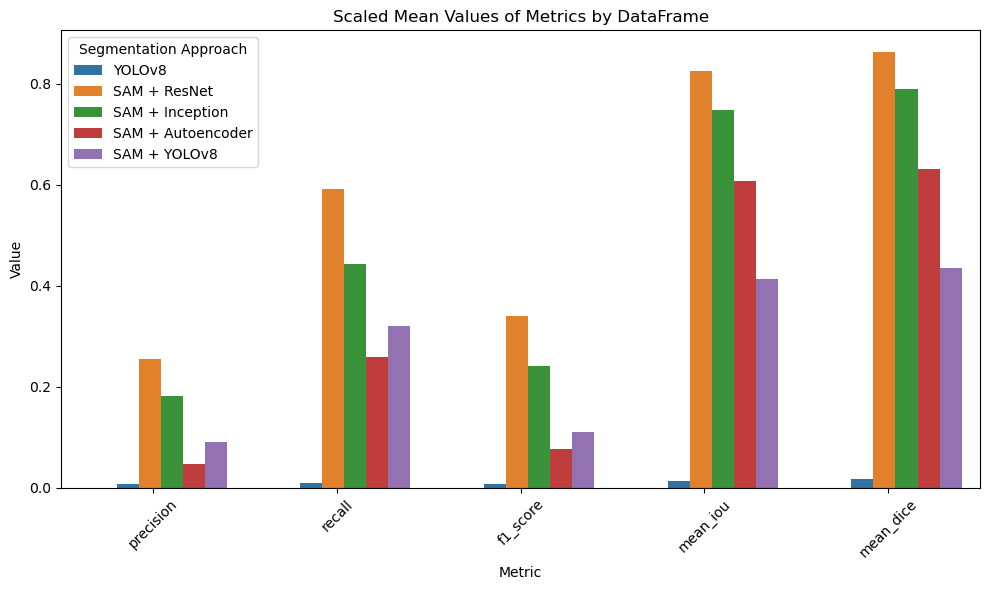

In [469]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
sns.barplot(x='Metric', y='Value', hue='Segmentation Approach', data=scaled_df_melted, dodge=True, width=0.6)

# Adjust the spacing between bar groups
ax = plt.gca()
for patch in ax.patches:
    patch.set_x(patch.get_x() + 0.1)  # Increase this value to add more space between groups

plt.title('Scaled Mean Values of Metrics by DataFrame')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("out/evaluation/synthetic/approaches_by_metrics.png", format="png")
plt.show()

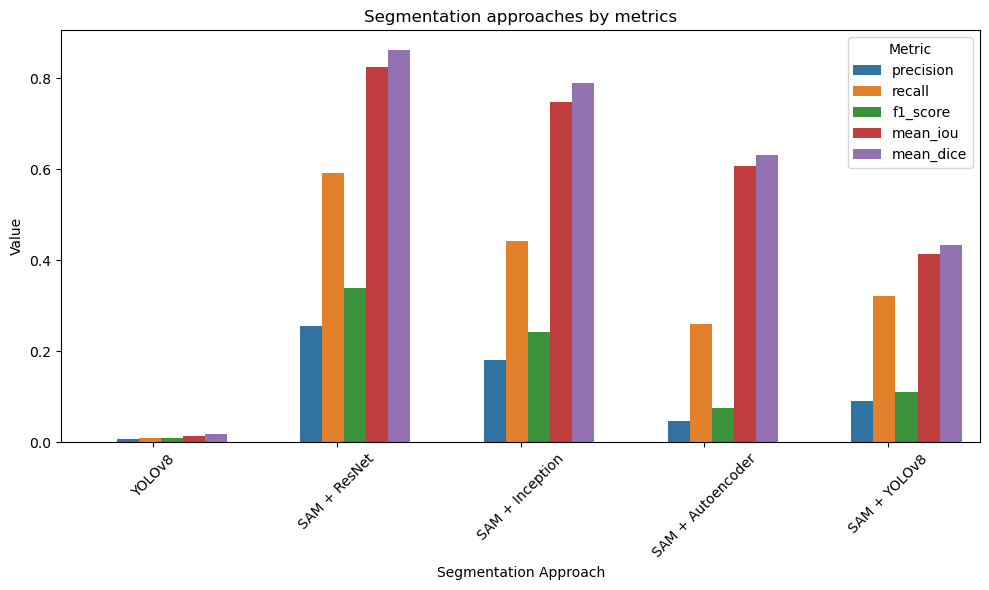

In [470]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
sns.barplot(x='Segmentation Approach', y='Value', hue='Metric', data=scaled_df_melted, dodge=True, width=0.6)

# Adjust the spacing between bar groups
ax = plt.gca()
for patch in ax.patches:
    patch.set_x(patch.get_x() + 0.1)  # Increase this value to add more space between groups

plt.title('Segmentation approaches by metrics')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("out/evaluation/synthetic/metrics_by_approach.png", format="png")
plt.show()

# Classification evaluation (PyTorch only)

In [69]:
import os
import torch
import random
import numpy as np
import torch.nn as nn
from tqdm import tqdm
from PIL import Image, ImageDraw
import pandas as pd
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.utils.class_weight import compute_sample_weight
from torchvision.datasets import CocoDetection

from ultralytics import YOLO
import torchvision.transforms.v2 as transforms

In [2]:
# Check if GPU is available
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
OUT_DIR = "out/evaluation"
os.makedirs(OUT_DIR, exist_ok=True)

In [4]:
class BinaryResnetClassifier(nn.Module):
    def __init__(self, num_classes=1):
        super(BinaryResnetClassifier, self).__init__()
        # Load a pre-trained ResNet model
        self.resnet = resnet50()  # You can choose any ResNet variant
        # Modify the last fully connected layer
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)
        nn.init.xavier_normal_(self.resnet.fc.weight)
        
    def forward(self, x):
        # Pass the input through the ResNet
        x = self.resnet(x)
        # Apply the sigmoid activation function
#        x = torch.sigmoid(x)  # Output will be between 0 and 1
        return x

In [5]:
class Encoder(nn.Module):
    def __init__(self, in_channels=3, out_channels=16, latent_dim=200, act_fn=nn.ReLU()):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1, stride=2),  # 112x112
            act_fn,
            nn.Conv2d(out_channels, 2*out_channels, 3, padding=1, stride=2),  # 56x56
            act_fn,
            nn.Conv2d(2*out_channels, 4*out_channels, 3, padding=1, stride=2),  # 28x28
            act_fn,
            nn.Conv2d(4*out_channels, 8*out_channels, 3, padding=1, stride=2),  # 14x14
            act_fn,
            nn.Conv2d(8*out_channels, 16*out_channels, 3, padding=1, stride=2),  # 7x7
            act_fn,
            nn.Flatten(),
            nn.Linear(16*out_channels*7*7, latent_dim),
            act_fn
        )

    def forward(self, x):
        return self.net(x)

class Decoder(nn.Module):
    def __init__(self, in_channels=3, out_channels=16, latent_dim=200, act_fn=nn.ReLU()):
        super().__init__()
        self.out_channels = out_channels
        self.linear = nn.Sequential(
            nn.Linear(latent_dim, 16*out_channels*7*7),
            act_fn
        )
        self.conv = nn.Sequential(
            nn.ConvTranspose2d(16*out_channels, 8*out_channels, 3, stride=2, padding=1, output_padding=1),  # 14x14
            act_fn,
            nn.ConvTranspose2d(8*out_channels, 4*out_channels, 3, stride=2, padding=1, output_padding=1),  # 28x28
            act_fn,
            nn.ConvTranspose2d(4*out_channels, 2*out_channels, 3, stride=2, padding=1, output_padding=1),  # 56x56
            act_fn,
            nn.ConvTranspose2d(2*out_channels, out_channels, 3, stride=2, padding=1, output_padding=1),  # 112x112
            act_fn,
            nn.ConvTranspose2d(out_channels, in_channels, 3, stride=2, padding=1, output_padding=1),  # 224x224
        )

    def forward(self, x):
        output = self.linear(x)
        output = output.view(-1, 16*self.out_channels, 7, 7)
        output = self.conv(output)
        return output

#  defining autoencoder
class BigAutoencoder(nn.Module):
    def __init__(self, encoder=Encoder(), decoder=Decoder()):
        super().__init__()
        self.encoder = encoder
#        self.encoder.to(device)

        self.decoder = decoder
#        self.decoder.to(device)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
yolo = YOLO("out/yolo_urban_street/train/weights/best.pt")

resnet = torch.load("out/leaf_classifier/resnet_masked_cos/resnet_best.pth")
resnet = resnet.to(device)
resnet.eval()

resnet_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.ToDtype(torch.float32, scale=True),
    #transforms.RandomAffine(180, shear=45),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  
])


autoencoder = torch.load("out/leaf_classifier/autoencoder/autoencoder_latest.pth")
autoencoder.eval()

autoencoder_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  
])

In [63]:
def prep_img(img):
    return torch.Tensor(img).to(device).unsqueeze(0)

def predict_autoencoder(img):
    def pred(x):
        x = autoencoder_transform(prep_img(x))
        gt = autoencoder_transform(prep_img(img))
        with torch.no_grad():
            val = nn.MSELoss()(autoencoder(x), gt).item()
            return val < .2
    return pred(img)
    
def predict_resnet(img):
    x = resnet_transform(img.unsqueeze(0))
    with torch.no_grad():
        out = resnet(x)
        sig = torch.sigmoid(out).item()
        return sig < .2
    
def predict_yolo(img):
    return yolo.predict(img.unsqueeze(0), verbose=False)[0].masks is not None

In [64]:
classification_dict = {
    "Autoencoder": predict_autoencoder,
    "ResNet": predict_resnet,
    "YOLOv8": predict_yolo,
}

In [10]:
import os
import json
from pycocotools.coco import COCO

def combine_coco_datasets(coco_files, output_file):
    combined_data = {
        'images': [],
        'annotations': [],
        'categories': []
    }

    category_mapping = {}
    current_image_id = 1  # Start from 1 for unique image IDs

    # Get the output directory from the output file path
    output_dir = os.path.dirname(output_file)

    for coco_file in coco_files:
        # Load COCO dataset
        coco = COCO(coco_file)

        # Extract the base directory from the COCO file path
        base_dir = os.path.dirname(coco_file)

        # Load categories and update the mapping
        categories = coco.loadCats(coco.getCatIds())
        for category in categories:
            if category['id'] not in category_mapping:
                category_mapping[category['id']] = {
                    'id': category['id'],
                    'name': category['name'],
                    'supercategory': category['supercategory']
                }

        # Update combined categories
        combined_data['categories'] = list(category_mapping.values())

        # Load images and annotations
        for img_id in coco.imgs.keys():
            img_info = coco.imgs[img_id]
            # Update image IDs to avoid duplication
            img_info['id'] = current_image_id

            # Convert the image file name to an absolute path
            img_info['file_name'] = os.path.abspath(os.path.join(base_dir, img_info['file_name']))
            combined_data['images'].append(img_info)
            current_image_id += 1

            # Load and update annotations
            annotation_ids = coco.getAnnIds(imgIds=img_id)
            for ann_id in annotation_ids:
                annotation = coco.anns[ann_id]
                annotation['image_id'] = img_info['id']  # Set the new image ID
                combined_data['annotations'].append(annotation)

    # Convert absolute paths back to relative paths based on the output directory
    #for img in combined_data['images']:
    #    img['file_name'] = os.path.relpath(img['file_name'], output_dir)

    # Save the combined dataset to a new JSON file
    with open(output_file, 'w') as f:
        json.dump(combined_data, f, indent=4)

In [11]:
COMBINE = False

coco_datasets = [
    "_data/validation/train/_annotations.coco.json",
    "_data/validation/test/_annotations.coco.json",
    "_data/validation/valid/_annotations.coco.json"
]

coco_output_file = "_data/validation_total.coco.json"

if COMBINE:
    combine_coco_datasets(coco_datasets, coco_output_file)

In [12]:
from pycocotools import mask as maskUtils
from pycocotools.coco import COCO

class CombinedDataset(Dataset):
    def __init__(self, coco_json_path, png_dir, coco_class_id, transform=None, max_png_files=None):
        """
        Args:
            coco_json_path (str): Path to COCO annotations JSON file.
            coco_images_dir (str): Directory containing COCO images.
            png_dir (str): Directory containing PNG files.
            coco_class_id (int): The COCO class ID to filter.
            transform (callable, optional): Optional transform to be applied on a sample.
            max_png_files (int, optional): Maximum number of PNG files to read.
        """
        self.coco = COCO(coco_json_path)
        self.png_files = [f for f in os.listdir(png_dir) if f.endswith('.png')]
        self.png_dir = png_dir
        self.coco_class_id = coco_class_id
        self.transform = transform
        self.max_png_files = max_png_files if max_png_files is not None else len(self.png_files)
        self.png_index = 0  # To track the current PNG file index
        self.image_ids = self.coco.getImgIds(catIds=[self.coco_class_id])
        self.total_coco_images = len(self.image_ids)

    def __len__(self):
        return self.total_coco_images + self.max_png_files

    def __getitem__(self, idx):
        if idx < self.total_coco_images:
            # Get COCO image ID
            img_id = self.image_ids[idx]
            img_info = self.coco.imgs[img_id]
            img_path = img_info['file_name']
            img = Image.open(img_path).convert('RGB')
            
            # Get segmentation masks
            ann_ids = self.coco.getAnnIds(imgIds=img_id, catIds=[self.coco_class_id])
            anns = self.coco.loadAnns(ann_ids)
            
            # Initialize a mask for the image
            mask = np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)

            # Generate masks for each annotation and combine them
            for ann in anns:
                rle = maskUtils.frPyObjects(ann['segmentation'], img_info['height'], img_info['width'])
                mask += maskUtils.decode(rle).squeeze()  # Combine the mask with the existing mask

            # Convert the mask to a PIL image
            mask = Image.fromarray(mask.astype(np.uint8) * 255)  # Convert to 0-255 range

            # Apply the mask to the image
            img_with_mask = Image.new('RGB', img.size)
            img_with_mask.paste(img, (0, 0), mask)

            if self.transform:
                img_with_mask = self.transform(img_with_mask)

            return img_with_mask, 1
        else:
            # Load PNG files when COCO dataset is exhausted
            png_file = self.png_files[self.png_index]
            png_image = Image.open(os.path.join(self.png_dir, png_file)).convert('RGBA')
            # Extract the alpha channel as the mask
            mask = png_image.split()[-1]  # Get the alpha channel
            
            # Create an image with the alpha mask applied
            img_with_mask = Image.new('RGB', png_image.size)
            img_with_mask.paste(png_image, (0, 0), mask)

            self.png_index += 1
            if self.png_index >= self.max_png_files:
                self.png_index = 0  # Loop back to the start of PNG files

            if self.transform:
                img_with_mask = self.transform(img_with_mask)

            return img_with_mask, 0

In [13]:
# Define your transform
transform = transforms.Compose([
    transforms.Resize((640, 640)),
    transforms.ToTensor(),
])
subset_size = 1000
dataset = CombinedDataset(coco_output_file, 
                          png_dir="_data/synthetic-dataset-generation/data/distractors/openimage", 
                          coco_class_id=1,
                          transform=transform,
                          max_png_files=500)

# Create a DataLoader for the subset
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

loading annotations into memory...
Done (t=0.33s)
creating index...
index created!


tensor(0)


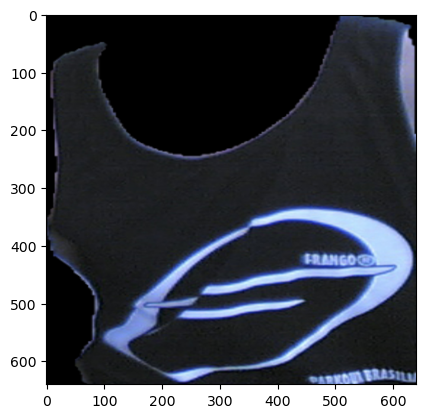

In [30]:
import matplotlib.pyplot as plt
batch = next(iter(dataloader))
img = batch[0][0]
print(batch[1][0])
plt.imshow(img.permute((1,2,0)))
plt.show()

In [70]:
def validate(model, dataloader, device):
    all_preds = []
    all_labels = []
    all_metrics = []  # List to store metrics for each batch
    
    with torch.no_grad():  # Disable gradient computation for validation
        for inputs, labels in tqdm(dataloader, total=len(dataloader)):
            inputs, labels = inputs.to(device), labels
            inputs = inputs.squeeze()
            
            # Forward pass
            outputs = model(inputs)
            preds = [int(outputs)]
            #print(preds, labels.item())

            #print(preds,labels)
            
            # Store predictions and true labels for metrics
            all_preds.extend(preds)
            all_labels.extend(labels)
            
            # Calculate metrics for the batch
            accuracy = accuracy_score(labels, preds)
            precision = precision_score(labels, preds, average='weighted', zero_division=0)
            recall = recall_score(labels, preds, average='weighted', zero_division=0)
            f1 = f1_score(labels, preds, average='weighted', zero_division=0)
            
            # Store metrics for this batch
            all_metrics.append({
                'batch_accuracy': accuracy,
                'batch_precision': precision,
                'batch_recall': recall,
                'batch_f1_score': f1
            })
    
    # Convert to DataFrame
    metrics_df = pd.DataFrame(all_metrics)
    
    coco_weight = dataset.total_coco_images / len(dataset)
    sample_weight = compute_sample_weight({0: coco_weight, 1: 1-coco_weight}, all_labels)
    
    # Compute overall metrics
    overall_accuracy = accuracy_score(all_labels, all_preds, sample_weight=sample_weight)
    overall_precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0, sample_weight=sample_weight)
    overall_recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0, sample_weight=sample_weight)
    overall_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0, sample_weight=sample_weight)
    overall_auc = roc_auc_score(all_labels, all_preds, average='weighted', sample_weight=sample_weight)
    
    # Add overall metrics to the DataFrame
    overall_metrics = pd.DataFrame({
        'overall_accuracy': [overall_accuracy],
        'overall_precision': [overall_precision],
        'overall_recall': [overall_recall],
        'overall_f1_score': [overall_f1],
        'overall_auc': [overall_auc]
    })
    
    return metrics_df, overall_metrics, all_labels, all_preds

In [71]:
result_dfs = {}
overalls = {}
preds = {}
for name, func in classification_dict.items():
    print(f"Evaluating {name}")
    df, overall, y_true, y_pred = validate(func, dataloader, device)
    df.to_csv(f"out/evaluation/{name}_eval.csv")
    overall.to_csv(f"out/evaluation/{name}_overall.csv")
    result_dfs[name] = df
    overalls[name] = overall
    preds[name] = {
        'y_true': y_true,
        'y_pred': y_pred
    }
    print(overall)

Evaluating Autoencoder


100%|██████████| 851/851 [00:38<00:00, 22.12it/s]


   overall_accuracy  overall_precision  overall_recall  overall_f1_score  \
0          0.655558           0.671759        0.655558           0.64724   

   overall_auc  
0     0.655558  
Evaluating ResNet


100%|██████████| 851/851 [00:47<00:00, 17.76it/s]


   overall_accuracy  overall_precision  overall_recall  overall_f1_score  \
0          0.957906            0.95802        0.957906          0.957903   

   overall_auc  
0     0.957906  
Evaluating YOLOv8


100%|██████████| 851/851 [00:56<00:00, 15.00it/s]


   overall_accuracy  overall_precision  overall_recall  overall_f1_score  \
0          0.717453           0.802801        0.717453          0.696034   

   overall_auc  
0     0.717453  


In [72]:
models_metrics = dict()

for key, value in overalls.items():
    models_metrics[key] = dict()
    for subkey, subvalue in value.items():
        models_metrics[key][subkey] = float(subvalue.iloc[0])

df = pd.DataFrame.from_dict(models_metrics, orient='index')

# Reset index to turn the model names into a column
df.reset_index(inplace=True)

# Rename the index column to 'model'
df.rename(columns={'index': 'model'}, inplace=True)

# Convert DataFrame to long format
df_long = pd.melt(df, id_vars=['model'], var_name='metric', value_name='value')

In [89]:
df
df.to_latex(float_format="%.4f")

'\\begin{tabular}{llrrrrr}\n\\toprule\n & model & overall_accuracy & overall_precision & overall_recall & overall_f1_score & overall_auc \\\\\n\\midrule\n0 & Autoencoder & 0.6556 & 0.6718 & 0.6556 & 0.6472 & 0.6556 \\\\\n1 & ResNet & 0.9579 & 0.9580 & 0.9579 & 0.9579 & 0.9579 \\\\\n2 & YOLOv8 & 0.7175 & 0.8028 & 0.7175 & 0.6960 & 0.7175 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [85]:
rename_dict = {
    'overall_accuracy': 'Accuracy',
    'overall_precision': 'Precision',
    'overall_recall': 'Recall',
    'overall_f1_score': 'F1-Score',
    "overall_auc": "AuC"
}

df_long['metric'] = df_long['metric'].replace(rename_dict)
df_long.drop(df_long.loc[(df_long['metric']=="Accuracy")].index, inplace=True)
df_long.drop(df_long.loc[(df_long['metric']=="AuC")].index, inplace=True)

df_long

,model,metric,value
3,Autoencoder,Precision,0.671759
4,ResNet,Precision,0.958020
5,YOLOv8,Precision,0.802801
6,Autoencoder,Recall,0.655558
7,ResNet,Recall,0.957906
8,YOLOv8,Recall,0.717453
9,Autoencoder,F1-Score,0.647240
10,ResNet,F1-Score,0.957903
11,YOLOv8,F1-Score,0.696034


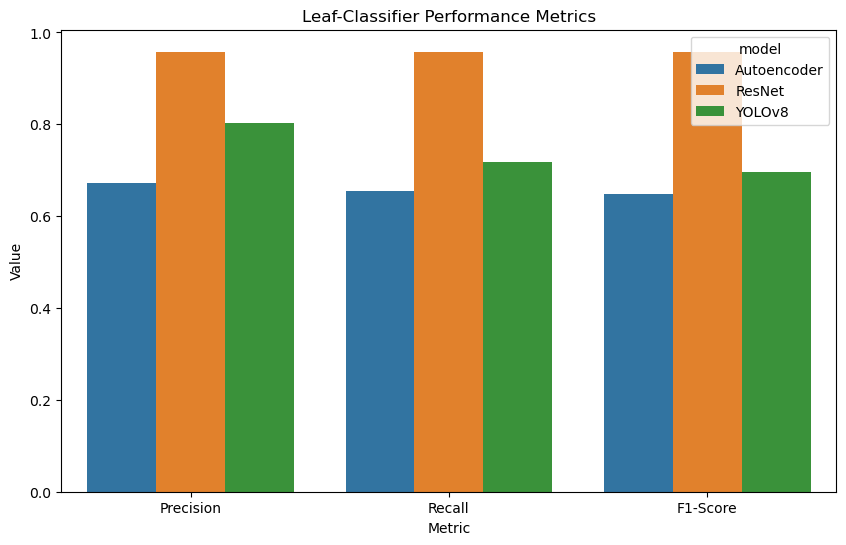

In [86]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a grouped bar plot using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='metric', y='value', hue='model', data=df_long)

# Add labels and title
plt.xlabel('Metric')
plt.ylabel('Value')
plt.title('Leaf-Classifier Performance Metrics')

# Show plot
plt.show()

In [50]:
import matplotlib.pyplot as plt

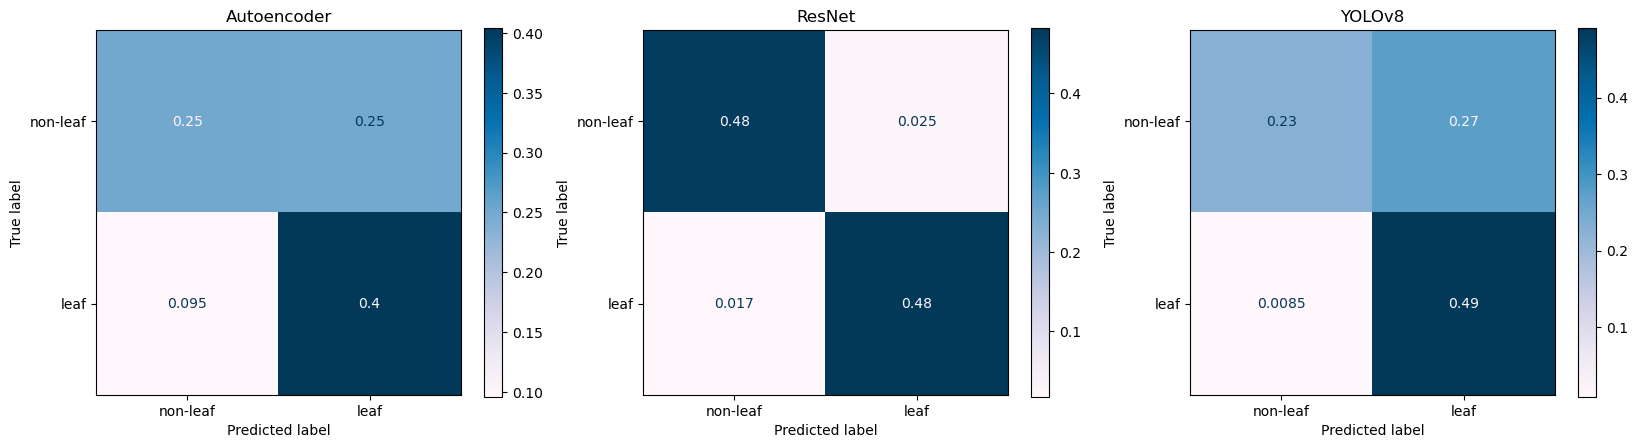

In [87]:
from sklearn.metrics import ConfusionMatrixDisplay
fig, axs = plt.subplots(1, 3)
fig.set_figwidth(20)
axs = axs.flatten()
for ax, (name, data) in zip(axs, preds.items()):
    data['y_true'] = [x.item() if type(x) is not int else x for x in data['y_true']]
    
    coco_weight = dataset.total_coco_images / len(dataset)
    sample_weight = compute_sample_weight({0: coco_weight, 1: 1 - coco_weight}, data['y_true'])
    disp = ConfusionMatrixDisplay.from_predictions(
        data['y_true'],
        data['y_pred'],
        cmap=plt.cm.PuBu,
        normalize='all',
        display_labels=['non-leaf', 'leaf'],
        ax=ax,
        sample_weight=sample_weight
    )
    disp.ax_.set_title(name)
plt.show()

In [ ]:
from sklearn.metrics import RocCurveDisplay
fig, axs = plt.subplots(1, 3)
fig.set_figwidth(20)
axs = axs.flatten()
for ax, (name, data) in zip(axs, preds.items()):
    data['y_true'] = [x.item() if type(x) is not int else x for x in data['y_true']]
    disp = RocCurveDisplay.from_predictions(
        data['y_true'],
        data['y_pred'],
        ax=ax
    )
    disp.ax_.set_title(name)
plt.show()

In [ ]:
from sklearn.metrics import PrecisionRecallDisplay
fig, axs = plt.subplots(1, 3)
fig.set_figwidth(20)
axs = axs.flatten()
for ax, (name, data) in zip(axs, preds.items()):
    data['y_true'] = [x.item() if type(x) is not int else x for x in data['y_true']]
    disp = PrecisionRecallDisplay.from_predictions(
        data['y_true'],
        data['y_pred'],
        ax=ax
    )
    disp.ax_.set_title(name)
plt.show()